# Multiclass classification: Reuters newswires 

We will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset

The Reuters dataset is a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras:

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


Like with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples. Check:

In [2]:
train_data.shape

(8982,)

In [3]:
test_data.shape

(2246,)

In [6]:
train_labels[0:20]

array([ 3,  4,  3,  4,  4,  4,  4,  3,  3, 16,  3,  3,  4,  4, 19,  8, 16,
        3,  3, 21])

In [7]:
test_labels[0:20]

array([ 3, 10,  1,  4,  4,  3,  3,  3,  3,  3,  5,  4,  1,  3,  1, 11, 23,
        3, 19,  3])

As with the IMDB reviews, each example is a list of integers (word indices):

In [9]:
train_data

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
       list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110,

In order to decode it, we can use the Reuters dictionary: 

In [16]:
word_index = reuters.get_word_index()

In [22]:
print("stock market = ", word_index.get("stock"), word_index.get("market"))

stock market =  77 73


and invert it:

In [17]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

which allows us to decode a single newswire:

In [21]:
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[2]])
decoded_newswire

'? shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one split effective january 6 1987 per share amounts are calculated after preferred stock dividends loss continuing operations for the qtr 1986 includes gains of sale of investments in ? corp of 14 mln dlrs and associated companies of 4 189 000 less writedowns of investments in national ? inc of 11 8 mln and ? corp of 15 6 mln reuter 3'

The topic of the story is labelled by an integer between 0 and 45.

In [23]:
train_labels[2]

3

## Preparing the data

We can vectorize the data with the exact same code as in the previous IMDB example:

In [24]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [ ]:
#def to_one_hot(labels, dimension=46):
#    results = np.zeros((len(labels), dimension))
#    for i, label in enumerate(labels):
#        results[i, label] = 1.
#    return results
#
## Our vectorized training labels
#one_hot_train_labels = to_one_hot(train_labels)
## Our vectorized test labels
#one_hot_test_labels = to_one_hot(test_labels)

An easier alternative is to use the built-in method in Keras:

In [25]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building the network

The 46-topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the dimensionality of the output space is much larger.

In a stack of Dense layers like what we were using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [26]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

We are ending the network with a Dense layer of size 46. This means that for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.

The last layer uses a softmax activation. It means that the network will output a probability distribution over the 46 different output classes, i.e. for every input sample, the network will produce a 46-dimensional output vector where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.

In [27]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

As in the MNIST example, the best loss function to use in the case of multiclass classification is categorical_crossentropy. It measures the distance between two probability distributions: in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the distance between these two distributions, we train our network to output something as close as possible to the true labels.

## Fitting and validation

Let's set apart 1,000 samples in our training data to use as a validation set:

In [28]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [29]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 54ms/step - loss: 2.4416 - accuracy: 0.5504 - val_loss: 1.6058 - val_accuracy: 0.6550
Epoch 2/20
16/16 [==============================] - 1s 42ms/step - loss: 1.3346 - accuracy: 0.7176 - val_loss: 1.2646 - val_accuracy: 0.7180
Epoch 3/20
16/16 [==============================] - 1s 43ms/step - loss: 1.0134 - accuracy: 0.7845 - val_loss: 1.1089 - val_accuracy: 0.7530
Epoch 4/20
16/16 [==============================] - 1s 42ms/step - loss: 0.7951 - accuracy: 0.8325 - val_loss: 1.0157 - val_accuracy: 0.7910
Epoch 5/20
16/16 [==============================] - 1s 42ms/step - loss: 0.6284 - accuracy: 0.8673 - val_loss: 0.9552 - val_accuracy: 0.8050
Epoch 6/20
16/16 [==============================] - 1s 42ms/step - loss: 0.4996 - accuracy: 0.8939 - val_loss: 0.9013 - val_accuracy: 0.8190
Epoch 7/20
16/16 [==============================] - 1s 43ms/step - loss: 0.3995 - accuracy: 0.9149 - val_loss: 0.9083 - val_accuracy: 0.8110
Epoch 8/20
16

In [32]:
history


Let's display its loss and accuracy curves:

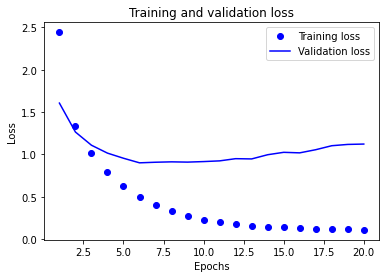

In [30]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

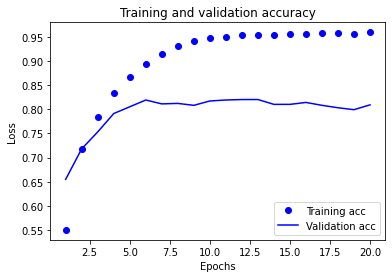

In [33]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The network begins to overfit after about 9 epochs. 

Let's now train a new network from scratch for 9 epochs, and evaluate it on the test set.

In [34]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 58ms/step - loss: 2.4779 - accuracy: 0.5417 - val_loss: 1.6344 - val_accuracy: 0.6270
Epoch 2/9
16/16 [==============================] - 1s 42ms/step - loss: 1.3479 - accuracy: 0.7184 - val_loss: 1.2757 - val_accuracy: 0.7330
Epoch 3/9
16/16 [==============================] - 1s 43ms/step - loss: 1.0022 - accuracy: 0.7889 - val_loss: 1.1163 - val_accuracy: 0.7600
Epoch 4/9
16/16 [==============================] - 1s 43ms/step - loss: 0.7900 - accuracy: 0.8319 - val_loss: 1.0185 - val_accuracy: 0.7790
Epoch 5/9
16/16 [==============================] - 1s 43ms/step - loss: 0.6258 - accuracy: 0.8676 - val_loss: 0.9551 - val_accuracy: 0.8000
Epoch 6/9
16/16 [==============================] - 1s 41ms/step - loss: 0.4997 - accuracy: 0.8949 - val_loss: 0.9232 - val_accuracy: 0.8090
Epoch 7/9
16/16 [==============================] - 1s 43ms/step - loss: 0.4029 - accuracy: 0.9157 - val_loss: 0.9139 - val_accuracy: 0.8080
Epoch 8/9
16/16 [===

Here are the final results:

In [35]:
results

[1.0118110179901123, 0.7911843061447144]

This approach reaches an accuracy of $~80\%$.

## Generating predictions on new data

Let's use the model to generate topic predictions for the stories in the test dataset:

In [36]:
predictions = model.predict(x_test)

Each entry in predictions is a vector of length 46:

In [37]:
predictions.shape

(2246, 46)

In [38]:
predictions[0]

array([2.09412810e-05, 1.29616019e-04, 9.96990548e-06, 8.79489243e-01,
       1.07068695e-01, 3.86528736e-05, 1.70599214e-05, 1.23473874e-04,
       1.29304093e-03, 4.47403227e-06, 9.60836333e-05, 1.03076152e-03,
       3.55629854e-05, 1.94546083e-04, 6.40990183e-05, 5.44030081e-06,
       3.17617739e-03, 2.11748891e-04, 1.20924979e-05, 5.54427505e-04,
       3.56280268e-03, 4.66529804e-04, 3.62279679e-05, 3.93284077e-04,
       1.95097782e-05, 4.15772993e-05, 2.47920752e-06, 5.01642353e-05,
       1.40912716e-05, 2.46690121e-04, 2.65985494e-04, 9.47088993e-05,
       4.25558501e-05, 1.45644581e-05, 3.47513793e-04, 1.00519719e-05,
       1.95938264e-04, 2.21674964e-05, 4.59737130e-05, 2.79582397e-04,
       1.33560825e-04, 8.16061147e-05, 2.38023677e-06, 4.23103374e-05,
       3.61578628e-07, 1.12494536e-05], dtype=float32)

Each of those numbers is the probability that the story belongs to the respective topic. These probabilities add up to 1:

In [39]:
np.sum(predictions[0])

1.0

We can declare the topic to be the one with the highest probability:

In [40]:
np.argmax(predictions[0])

3

Compare our answer to the true label:

In [41]:
test_labels[0]

3

## The importance of having sufficiently large intermediate layers

Since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 46-dimensional, e.g. 4-dimensional.

In [42]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 18ms/step - loss: 2.3581 - accuracy: 0.4937 - val_loss: 1.6388 - val_accuracy: 0.5450
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 1.3741 - accuracy: 0.6723 - val_loss: 1.3154 - val_accuracy: 0.6980
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 1.1012 - accuracy: 0.7321 - val_loss: 1.2369 - val_accuracy: 0.7090
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 0.9397 - accuracy: 0.7625 - val_loss: 1.2058 - val_accuracy: 0.7230
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8161 - accuracy: 0.7879 - val_loss: 1.2127 - val_accuracy: 0.7170
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.7165 - accuracy: 0.8106 - val_loss: 1.3517 - val_accuracy: 0.7090
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 0.6356 - accuracy: 0.8296 - val_loss: 1.3051 - val_accuracy: 0.7190
Epoch 8/20
63

The network accuracy drops from 79% to about 71%, a difference of 8%.

Let's make this even more extreme:

In [45]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 19ms/step - loss: 2.6346 - accuracy: 0.2878 - val_loss: 2.1108 - val_accuracy: 0.3540
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 2.0358 - accuracy: 0.3532 - val_loss: 1.9809 - val_accuracy: 0.3590
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 1.9143 - accuracy: 0.3542 - val_loss: 1.9388 - val_accuracy: 0.3640
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.8461 - accuracy: 0.3543 - val_loss: 1.9024 - val_accuracy: 0.3720
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.7920 - accuracy: 0.3644 - val_loss: 1.9021 - val_accuracy: 0.3810
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 1.7505 - accuracy: 0.4034 - val_loss: 1.8987 - val_accuracy: 0.4510
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 1.7169 - accuracy: 0.4486 - val_loss: 1.8917 - val_accuracy: 0.4740
Epoch 8/20
63

The ultimate bottleneck brings the accuracy down to 52%.

## Lessons from the classification example

Here's what you should take away from this example:

1. If you are trying to classify data points between N classes, your network should end with a Dense layer of size N.
2. In a single-label, multi-class classification problem, your network should end with a softmax activation, so that it will output a probability distribution over the N output classes.
3. Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network, and the true distribution of the targets.
4. The standard way to handle labels in multi-class classification is: encoding the labels via "categorical encoding" (also known as "one-hot  encoding") and using categorical_crossentropy as your loss function. (There are other methods which we did not talk about.)
5. If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having intermediate layers that are too small.

# Regression: Boston Housing Prices

We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the suburb at the time, such as the crime rate, the local property tax rate, etc.

## The Boston Housing Price dataset

This dataset has an interesting difference from our two previous examples: it has very few data points, only 506 in total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, others between 0 and 100, etc.

Let's take a look at the data:

In [46]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [47]:
train_data.shape

(404, 13)

In [48]:
test_data.shape

(102, 13)

In [50]:
test_data[0]

array([ 18.0846,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.434 ,
       100.    ,   1.8347,  24.    , 666.    ,  20.2   ,  27.25  ,
        29.05  ])

As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as follow:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (M - 0.63) ** 2 where M is the proportion of minority people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [49]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The prices are typically between \$10,000 and \$50,000. If that sounds cheap, remember this was the mid-1970s, and these prices are not inflation-adjusted.

## Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:

In [51]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the quantities that we use for normalizing the test data have been computed using the training data. We should never use in our workflow any quantity computed on the test data, even for something as simple as data normalization.

## Building the network

Because so few samples are available, we will be using a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

In [52]:
from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Our network ends with a single unit, and no activation (i.e. it will be linear layer). This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). Applying an activation function would constrain the range that the output can take; for instance if we applied a sigmoid activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the mse loss function -- Mean Squared Error, the square of the difference between the predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: mae. This stands for Mean Absolute Error. It is simply the absolute value of the difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by \$500 on average.

## Fitting and validation with K-fold validation

To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could simply split the data into a training set and a validation set, as we were doing in our previous examples. However, because we have so few data points, the validation set would end up being very small (e.g. about 100 examples). A consequence is that our validation scores may change a lot depending on which data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a high **variance** with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use $K$-fold cross-validation. It consists of splitting the available data into $K$ partitions (typically $K=4$ or $K=5$), then instantiating $K$ identical models, and training each one on $K-1$ partitions while evaluating on the remaining partition. The validation score for the model used would then be the average of the $K$ validation scores obtained.

In terms of code, this is straightforward:

In [53]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [54]:
all_scores

[2.0561254024505615, 2.4607367515563965, 3.2443315982818604, 2.522122859954834]

In [55]:
np.mean(all_scores)

2.570829153060913

As you can notice, the different runs do indeed show rather different validation scores, from 2.1 to 3.2. Their average (2.6) is a much more reliable metric than any single of these scores -- that's the entire point of K-fold cross-validation. In this case, we are off by \$2,600 on average, which is still significant considering that the prices range from \$10,000 to \$50,000.

Let's try training the network for a bit longer: 500 epochs (**be patient, this will take a few minutes**). To keep a record of how well the model did at each epoch, we will modify our training loop to save the per-epoch validation score log:

In [56]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [60]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
#    mae_history = history.history['val_mean_absolute_error']
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


We can then compute the average of the per-epoch MAE scores for all folds:

In [61]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Let's plot this:

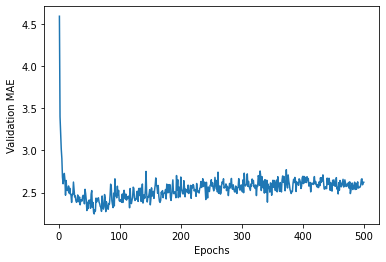

In [62]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let's:

1. Omit the first 10 data points, which are on a different scale from the rest of the curve.
2. Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

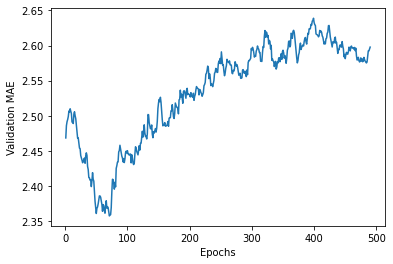

In [63]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

Once we are done tuning other parameters of our model (besides the number of epochs, we could also adjust the size of the hidden layers), we can train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data:

In [64]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 18.3252 - mae: 2.7636


In [65]:
test_mae_score

2.7635743618011475

We are still off by about \$2,760.

## Lessons from the regression example

Here's what you should take away from this example:
1. Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for regression.
2. Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
3. When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
4. When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
5. When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.